# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import itertools

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True})
# mpl.rcParams.update({"axes.grid": True})
sns.set()

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

See [pre-processing notebook](./mammoth_snowfall_datagen.ipynb) for how I generated this table from the Mammoth website data

## Read In

In [3]:
df = pd.read_csv(
    "./data/mammoth_mountain_snowfall_melted_table_with_monthly_average.csv"
)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df

,Month,Snow Fall,MonthlyAverage
Date,,,
1970-01-01,Jan,78.0,71.333333
1970-02-01,Feb,30.5,69.761111
1970-03-01,Mar,46.0,63.718519
1970-04-01,Apr,27.0,32.924074
1970-05-01,May,0.0,8.029630
...,...,...,...
2023-08-01,Aug,0.0,2.870370
2023-09-01,Sep,0.0,2.870370
2023-10-01,Oct,0.0,6.372222


In [4]:
if 0:
    df = df.reindex(pd.date_range(start=df.index[0], periods=len(df), freq="MS"))
    df.index.set_names("Date", inplace=True)
    df

# Extract Target

Arbitrarily limit from 2015 and on, to make the dataset easier to work with
- Also, stop it in May so that when predicting the last N months, we are finishing at the end of a ski season
- i.e. avoid trying to predict into the boring summer trough region

In [5]:
y_target = df["Snow Fall"]["2010":"2022-05-01"]

In [6]:
y_exog = df["MonthlyAverage"][y_target.index]
# y_exog = df["Can Snow"][y_target.index]
# y_exog = df[["MonthlyAverage", "Can Snow"]].loc[y_target.index, :]

# Plots of Data

## Raw Data

In [7]:
snowfall_period = 12

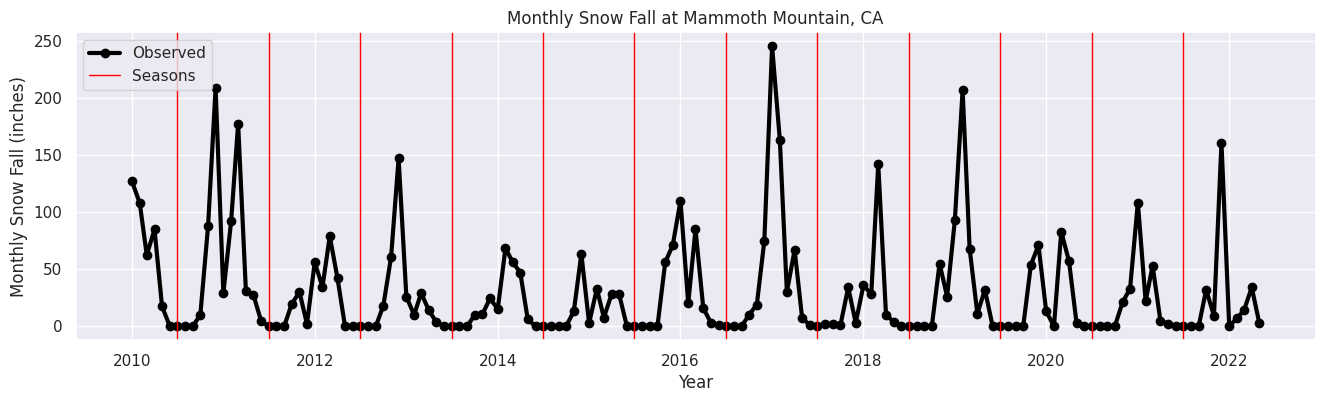

In [8]:
# plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(16, 4))
plt.plot(
    y_target,
    color="black",
    label="Observed",
    linestyle="solid",
    marker="o",
    lw=3,
)

# Plot verticals every July
for k in range(int(len(y_target) / snowfall_period)):
    idx = k * snowfall_period + np.argmax(y_target.index.month == 7)
    plt.axvline(
        y_target.index[int(idx)],
        color="red",
        label="Seasons" if k == 0 else None,
        lw=1,
    )

plt.title("Monthly Snow Fall at Mammoth Mountain, CA")
plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

## Seasonals

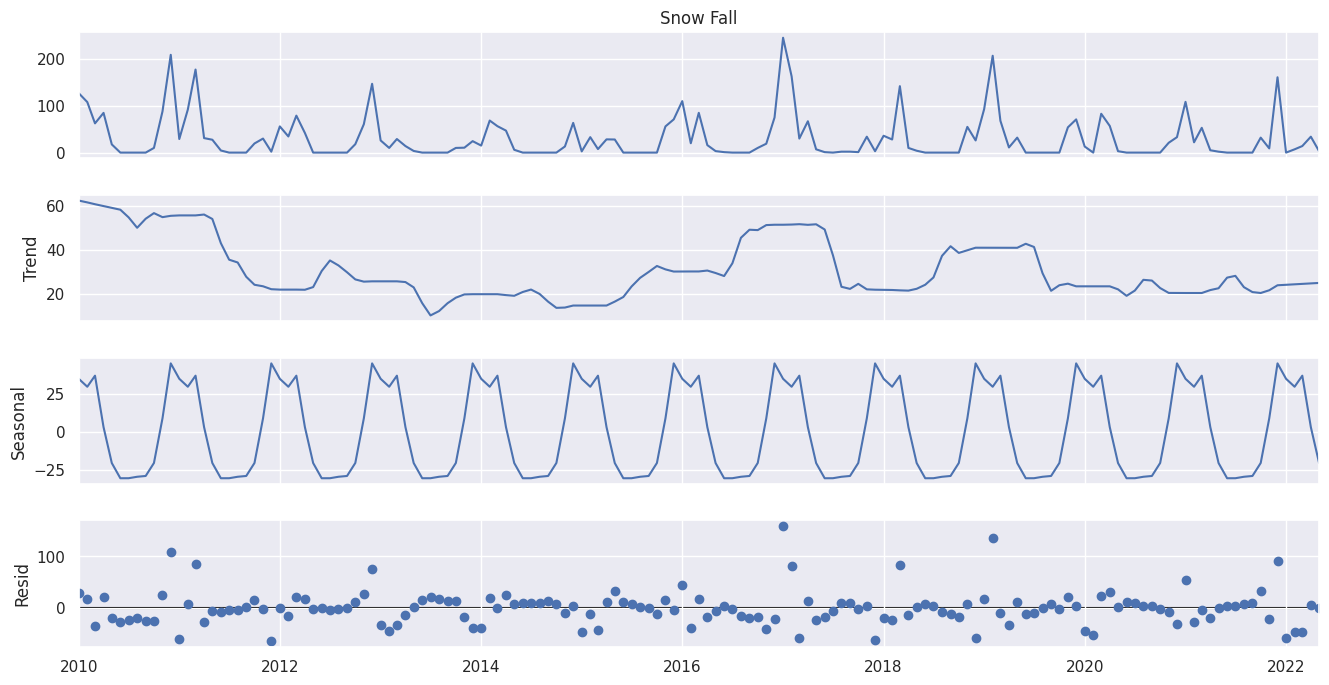

In [9]:
seasonal_decompose(
    y_target,
    model="additive",
    period=snowfall_period,
    extrapolate_trend=snowfall_period,
).plot(observed=True).set_size_inches((15, 7.5))

plt.show()

## Autocorrelation

In [10]:
def plot_acf_pacf(y):
    (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plot_acf(y, lags=10, ax=ax[0])
    ax[0].set_title("ACF - MA(q)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Corr")

    plot_pacf(y, lags=10, ax=ax[1])
    ax[1].set_title("PACF - AR(p)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Corr")
    plt.show()

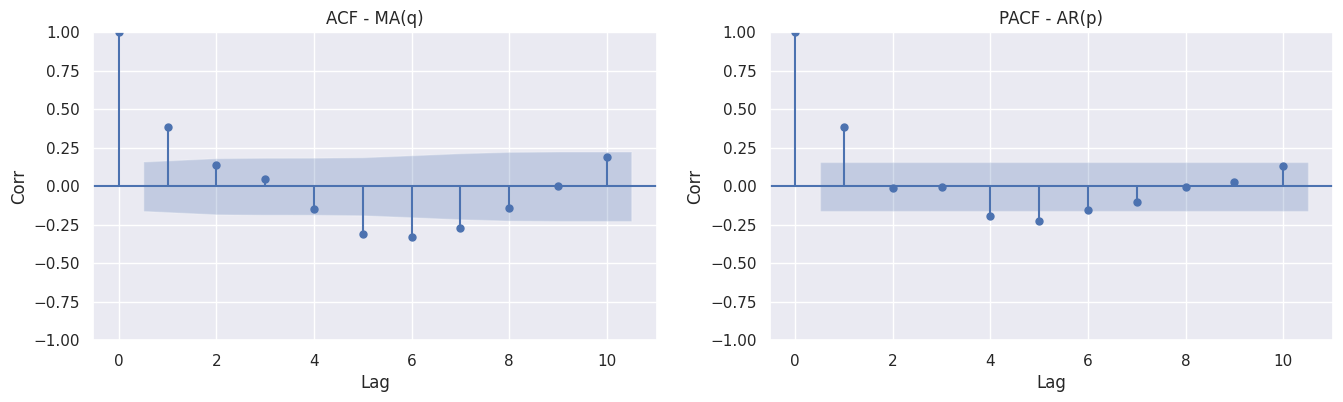

In [11]:
plot_acf_pacf(y_target)

# Train / Test Split

In [12]:
n_steps_future = 7

In [13]:
# Split
y_history, y_future, y_exog_history, y_exog_future = train_test_split(
    y_target, y_exog, shuffle=False, test_size=n_steps_future
)

if 0:
    # Disable exogenous features
    y_exog_history, y_exog_future = None, None

# Fit with ARIMA

## Helper Functions

In [14]:
def get_errors_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred).round(1),
        "rmse": root_mean_squared_error(y_true, y_pred).round(1),
    }

In [15]:
def get_estimator_and_errors(order, seasonal_order):
    # Fit
    estimator = ARIMA(
        y_history,
        order=order,
        seasonal_order=seasonal_order,
        exog=y_exog_history,
    ).fit()

    # Predict history and future
    y_hat = estimator.predict(
        start=y_history.index[0], end=y_future.index[-1], exog=y_exog_future
    )

    # Get errors
    (y_fit, y_forecast) = train_test_split(
        y_hat,
        shuffle=False,
        test_size=len(y_future),
    )

    train_test_errors = {
        "fit": get_errors_dict(y_history, y_fit),
        "forecast": get_errors_dict(y_future, y_forecast),
    }

    return estimator, y_hat, train_test_errors

## Search Grid

Over (p, d, q) for stationary and (p, d, q, **s**) for seasonal, with s fixed to known period

In [16]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
order_list = list(itertools.product(p, d, q))

sp = range(1, 3)
sd = range(0, 2)
sq = range(1, 3)
ss = [snowfall_period]

seasonal_order_list = list(itertools.product(sp, sd, sq, ss))

In [17]:
for order in order_list:
    print("order (p,d,q) = %s" % str(order))

for seasonal_order in seasonal_order_list:
    print("seasonal_order (p,d,q,s) = %s" % str(seasonal_order))

order (p,d,q) = (0, 0, 0)
order (p,d,q) = (0, 0, 1)
order (p,d,q) = (0, 0, 2)
order (p,d,q) = (0, 1, 0)
order (p,d,q) = (0, 1, 1)
order (p,d,q) = (0, 1, 2)
order (p,d,q) = (1, 0, 0)
order (p,d,q) = (1, 0, 1)
order (p,d,q) = (1, 0, 2)
order (p,d,q) = (1, 1, 0)
order (p,d,q) = (1, 1, 1)
order (p,d,q) = (1, 1, 2)
order (p,d,q) = (2, 0, 0)
order (p,d,q) = (2, 0, 1)
order (p,d,q) = (2, 0, 2)
order (p,d,q) = (2, 1, 0)
order (p,d,q) = (2, 1, 1)
order (p,d,q) = (2, 1, 2)
seasonal_order (p,d,q,s) = (1, 0, 1, 12)
seasonal_order (p,d,q,s) = (1, 0, 2, 12)
seasonal_order (p,d,q,s) = (1, 1, 1, 12)
seasonal_order (p,d,q,s) = (1, 1, 2, 12)
seasonal_order (p,d,q,s) = (2, 0, 1, 12)
seasonal_order (p,d,q,s) = (2, 0, 2, 12)
seasonal_order (p,d,q,s) = (2, 1, 1, 12)
seasonal_order (p,d,q,s) = (2, 1, 2, 12)


## Run the Search

In [18]:
num_runs_todo = len(order_list) * len(seasonal_order_list)

In [19]:
if 1:  # to bypass search and take saved best
    best_order, best_seasonal_order = (0, 0, 0), (2, 0, 2, snowfall_period)
else:
    best_error = np.Inf
    num_runs_done = 0
    for order in order_list:
        for seasonal_order in seasonal_order_list:
            estimator, y_hat, train_test_errors = get_estimator_and_errors(
                order, seasonal_order
            )

            num_runs_done += 1
            current_error = train_test_errors["forecast"]["mae"]
            if current_error < best_error:
                best_error = current_error
                best_order = order
                best_seasonal_order = seasonal_order
                print(
                    "New best at order = %s, seasonal_order = %s, search is %.2f%% complete\n\tAll errors = %s"
                    % (
                        best_order,
                        best_seasonal_order,
                        num_runs_done / num_runs_todo * 100.0,
                        str(train_test_errors),
                    )
                )

```
New best at order = (0, 0, 0), seasonal_order = (1, 0, 1, 12), search is 0.31% complete
	All errors = {'fit': {'mae': 19.9, 'rmse': 34.9}, 'forecast': {'mae': 42.6, 'rmse': 50.8}}
New best at order = (0, 0, 0), seasonal_order = (1, 0, 2, 12), search is 0.62% complete
	All errors = {'fit': {'mae': 20.6, 'rmse': 34.2}, 'forecast': {'mae': 36.8, 'rmse': 47.5}}
New best at order = (0, 0, 0), seasonal_order = (2, 0, 2, 12), search is 1.85% complete
	All errors = {'fit': {'mae': 20.3, 'rmse': 33.9}, 'forecast': {'mae': 35.9, 'rmse': 44.7}}
```

## Evaluate Best Model

In [20]:
estimator, y_hat, train_test_errors = get_estimator_and_errors(
    best_order, best_seasonal_order
)

In [21]:
print(
    "Evaluated model at order = %s, seasonal_order = %s\n\tAll errors = %s"
    % (
        best_order,
        best_seasonal_order,
        str(train_test_errors),
    )
)

Evaluated model at order = (0, 0, 0), seasonal_order = (2, 0, 2, 12)
	All errors = {'fit': {'mae': 20.3, 'rmse': 33.9}, 'forecast': {'mae': 35.9, 'rmse': 44.7}}


```
Evaluated model at order = (0, 0, 0), seasonal_order = (2, 0, 2, 12)
	All errors = {'fit': {'mae': 20.3, 'rmse': 33.9}, 'forecast': {'mae': 35.9, 'rmse': 44.7}}
```

# Data from Prior Runs

## File Names of Saved Results

Current model is on top, prior model is one down
- I made it a list to make it easier to slide new models on top

In [22]:
model_history_filename_stubs = [
    "monthly_snowfall_arima_with_exog_zero_order",
    "monthly_snowfall_arima_with_exog",
    "monthly_snowfall_arima_without_exog",
]

In [23]:
model_history_filenames = [
    "./data/" + stub + ".csv" for stub in model_history_filename_stubs
]

## Write New Results

If you changed the checkpoint filename on purpose, write out results

In [24]:
if not os.path.exists(model_history_filenames[0]):
    print("Writing new results checkpoint to file %s" % model_history_filenames[0])
    y_hat.to_csv(model_history_filenames[0], index_label="Date")

## Read Back Checkpoint and Prior Model

In [25]:
y_hat_checkpoint = pd.read_csv(
    model_history_filenames[0], index_col="Date", parse_dates=True
)[y_hat.name]

y_hat_prior_model = pd.read_csv(
    model_history_filenames[1], index_col="Date", parse_dates=True
)[y_hat.name]

## Assert Same

Verify no change from checkpoint, unless we wanted one

In [26]:
# Enable to demonstrate it's possible to fail checkpoint assessment
if 0:
    y_hat_checkpoint[0] += 1.0e-3

print(
    "Checkpoint vs. Current mismatch errors = %s"
    % get_errors_dict(y_hat, y_hat_checkpoint)
)

# pd.concat([y_hat, y_hat_checkpoint], axis=1)

# Assert same to get eyes on why different
pd.testing.assert_series_equal(
    y_hat, y_hat_checkpoint, check_names=False, check_freq=False
)

Checkpoint vs. Current mismatch errors = {'mae': 0.0, 'rmse': 0.0}


In [27]:
# plt.plot(y_hat - y_hat_checkpoint)
# sns.kdeplot((y_hat - y_hat_checkpoint) * 1.0e3, fill=True)  # , log_scale=0)

# Plots of Model Quality

## Plot Actuals and Model

### Code for

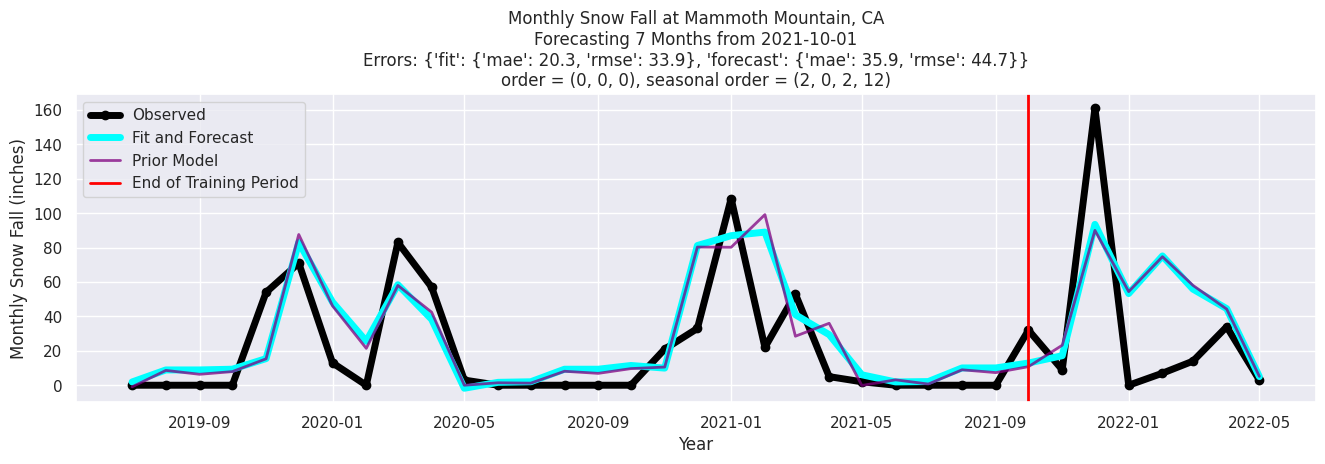

In [28]:
# nplot = len(y_target) - n_steps_future
nplot = 4 * n_steps_future

plt.figure(figsize=(16, 4))

plt.plot(
    y_target.tail(nplot + n_steps_future),
    color="black",
    label="Observed",
    linestyle="solid",
    marker="o",
    lw=5,
)

plt.plot(
    y_hat.tail(nplot + n_steps_future),
    color="cyan",
    label="Fit and Forecast",
    linestyle="solid",
    lw=5,
)

plt.plot(
    y_hat_prior_model.tail(nplot + n_steps_future),
    label="Prior Model",
    color="purple",
    lw=2,
    alpha=0.75,
)

plt.axvline(
    y_history.index[-1],
    color="red",
    label="End of Training Period",
    lw=2,
)

plt.title(
    "Monthly Snow Fall at Mammoth Mountain, CA\nForecasting %d Months from %s\nErrors: %s\norder = %s, seasonal order = %s"
    % (
        n_steps_future,
        str(y_target.index[-n_steps_future - 1]).split()[0],
        train_test_errors,
        best_order,
        best_seasonal_order,
    )
)

plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

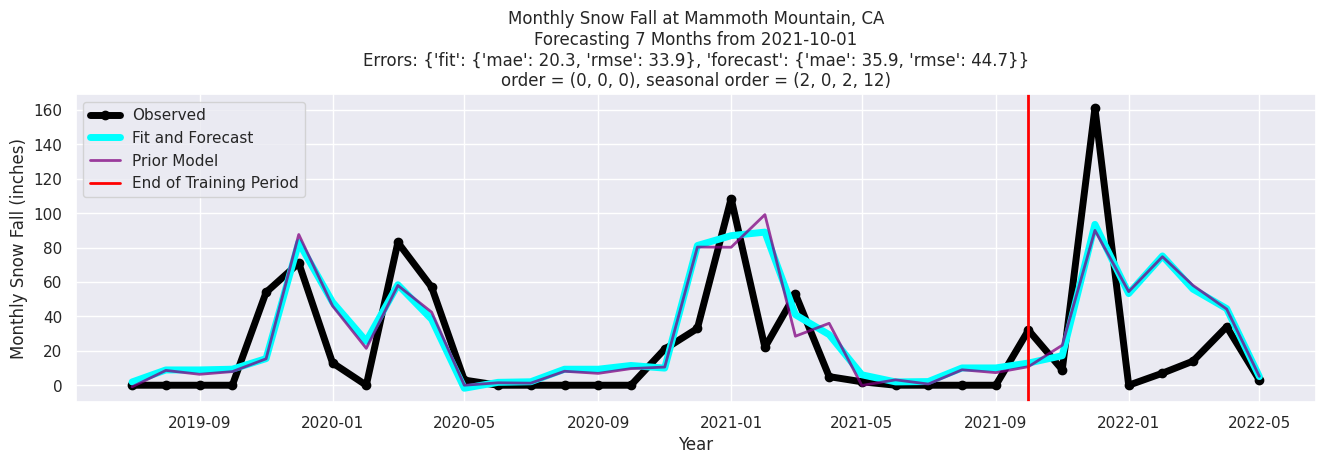

#### Save of plot, to scan for clues, if different for no apparent reason

## Autocorrelation of Residual

Look ma, all zeros

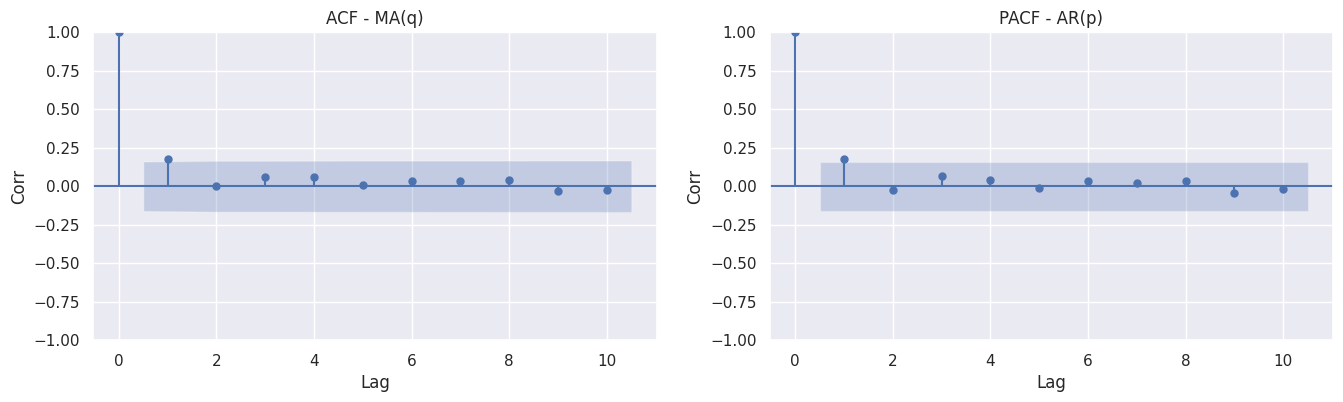

In [29]:
plot_acf_pacf(y_target - y_hat)

# To Do

Some things I wanted to but didn't have time to add
- Errata
    - I am using an exo feature - average snowfall per month - that erroneously uses "future" data
        - The average snowfall should be regenerated over just the history data
        - The truth is it won't matter, because it's just 1 year compared to > 50 years total data
        - But still, get it right
- Asses Model w.r.t to the trivial model
    - Here the trivial model is the long term monthly average
    - Is the model better than that?
    - I am guessing it is not
    - But check it, first and foremost overlay onto the plot what the monthly average prediction would be
    - Raw scores are difficult to understand in *so-what* terms
    - But if compared to the trivial model, a so-what can emerge
        - Had you just guessed the average, you would have been this much better/worse than the fancy model
- More Models = More Better?
    - SARIMAX
        - It's documentation says it handles exo features differently than does ARIMA
        - So I am especially curious how that will result, since I am using an exo feature (somewhat incorrectly - see above)
    - STL and STL Forecast
        - Here it gets a bit convoluted, because STL forecast uses arima
        - But I would like to know, if for nothing more than pedagogical purposes, would it be useful to do STL fit/forecast
            - And then operate thereafter on the residual
            - Seasonal decomp plot show there is substantial residual following detrend
            - So it would be nice to operate directly on that
            - And then form a composite prediction as
                - STL forecast + "model blah" of residual
            - And then compare to ARIMA
                - Which I think does it all in one shot via seasonal order parameter I am using
- More Exo = More Better?
    - Would other exo features help, such as average temperatures?
    - Presumably very correlated with snowfall
    - What about number of visitors to Mammoth?
        - More snow tends to draw more visitors, conversely, if there are more visitors, there is probably more snow
        - What is the right time frame though for this, must it be an average?
            - If so, likely to be another version of the average monthly snowfall
            - So, not wrong, but also not informative
- The monthly data is so choppy that I am skeptical that any worthwhile prediction can be made from it
    - What if it were interpolated to a higher density, say, weeks, or even days?
    - Integrate, interpolate (spline), then differentiate
    - Interested to know if we can then track locally understandable trends
    - It would be synthetic at that point, but it might be much more interesting
    - Understand that any interpolation scheme imposes a new snowfall record that is made up
        - i.e. there are ininite number of different daily snowfall patterns that could have contributed the monthly total
- Is the entire time scale inappropriate given the reality of weather?
    - Wonder if it makes more sense to zoom in even closer
    - e.g. if it's snowed this much now, how much will it snow next week?